For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%. 

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score

from tensorflow.keras.layers import LSTM, GRU, Dense, Input, RepeatVector, TimeDistributed, Masking
from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, Lambda, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, plot_model
import tensorflow.keras.backend as K
import tensorflow as tf
import tensorflow.keras as keras

import random

In [2]:
np.random.seed(42)

In [3]:
n = 50000

In [4]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [5]:
xl, ll, yl = [], [], []
for _ in range(n):
    cl = (np.random.rand(5)<.25).astype(np.float32)
    row = createRow(np.random.randint(40,60), cl)
    ll.append([_,len(row)])
    xl.append(row)
    yl.append(cl)
    

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-01-05 10:34:58.235060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 10:34:58.315273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 10:34:58.315722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [7]:
#import train_test_split
from sklearn.model_selection import train_test_split

In [8]:
X = keras.preprocessing.sequence.pad_sequences(
    xl, padding="post", dtype="float32"
)
X = tf.convert_to_tensor(X, dtype=tf.float32)
y = tf.convert_to_tensor(yl, dtype=tf.float32)
lengths = tf.convert_to_tensor(ll, dtype=tf.int32)
X.shape, y.shape, lengths.shape

2022-01-05 10:35:00.628689: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-05 10:35:00.631310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 10:35:00.631793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 10:35:00.632188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

(TensorShape([50000, 59, 3]), TensorShape([50000, 5]), TensorShape([50000, 2]))

In [9]:
X_train, y_train, X_valid, y_valid = X[:35000], y[:35000], X[35000:], y[35000:]
lengths_train, lengths_valid = lengths[:35000], lengths[35000:]

In [10]:
X_train.shape, y_train.shape

(TensorShape([35000, 59, 3]), TensorShape([35000, 5]))

## 1st model

Epoch 1/200
69/69 [==============================] - 6s 31ms/step - loss: 0.5995 - acc: 0.1498 - precision_2: 0.2743 - recall_2: 0.4866 - val_loss: 0.5323 - val_acc: 0.1746 - val_precision_2: 0.4193 - val_recall_2: 0.4055
Epoch 2/200
69/69 [==============================] - 1s 17ms/step - loss: 0.4929 - acc: 0.2331 - precision_2: 0.5960 - recall_2: 0.3848 - val_loss: 0.4604 - val_acc: 0.2591 - val_precision_2: 0.7080 - val_recall_2: 0.3906
Epoch 3/200
69/69 [==============================] - 1s 17ms/step - loss: 0.4514 - acc: 0.3659 - precision_2: 0.8123 - recall_2: 0.3479 - val_loss: 0.4534 - val_acc: 0.4556 - val_precision_2: 0.8794 - val_recall_2: 0.3228
Epoch 4/200
69/69 [==============================] - 1s 17ms/step - loss: 0.4272 - acc: 0.4273 - precision_2: 0.9822 - recall_2: 0.3468 - val_loss: 0.4183 - val_acc: 0.3699 - val_precision_2: 0.9872 - val_recall_2: 0.3492
Epoch 5/200
69/69 [==============================] - 1s 19ms/step - loss: 0.4123 - acc: 0.3719 - precision_2: 0.

Epoch 38/200
69/69 [==============================] - 1s 19ms/step - loss: 0.1712 - acc: 0.4997 - precision_2: 0.9895 - recall_2: 0.7445 - val_loss: 0.1809 - val_acc: 0.5075 - val_precision_2: 0.9806 - val_recall_2: 0.7258
Epoch 39/200
69/69 [==============================] - 1s 19ms/step - loss: 0.1670 - acc: 0.4983 - precision_2: 0.9918 - recall_2: 0.7514 - val_loss: 0.1646 - val_acc: 0.4961 - val_precision_2: 0.9900 - val_recall_2: 0.7557
Epoch 40/200
69/69 [==============================] - 1s 17ms/step - loss: 0.1603 - acc: 0.4969 - precision_2: 0.9910 - recall_2: 0.7649 - val_loss: 0.1563 - val_acc: 0.5107 - val_precision_2: 0.9932 - val_recall_2: 0.7685
Epoch 41/200
69/69 [==============================] - 1s 19ms/step - loss: 0.1556 - acc: 0.4947 - precision_2: 0.9921 - recall_2: 0.7711 - val_loss: 0.1526 - val_acc: 0.4867 - val_precision_2: 0.9972 - val_recall_2: 0.7707
Epoch 42/200
69/69 [==============================] - 1s 19ms/step - loss: 0.1856 - acc: 0.4783 - precision_

Epoch 75/200
69/69 [==============================] - 1s 19ms/step - loss: 0.0988 - acc: 0.5161 - precision_2: 0.9873 - recall_2: 0.8761 - val_loss: 0.0956 - val_acc: 0.5213 - val_precision_2: 0.9794 - val_recall_2: 0.8879
Epoch 76/200
69/69 [==============================] - 1s 17ms/step - loss: 0.0974 - acc: 0.5132 - precision_2: 0.9844 - recall_2: 0.8806 - val_loss: 0.0939 - val_acc: 0.5183 - val_precision_2: 0.9911 - val_recall_2: 0.8827
Epoch 77/200
69/69 [==============================] - 1s 20ms/step - loss: 0.0945 - acc: 0.5150 - precision_2: 0.9844 - recall_2: 0.8871 - val_loss: 0.0951 - val_acc: 0.5324 - val_precision_2: 0.9862 - val_recall_2: 0.8851
Epoch 78/200
69/69 [==============================] - 1s 21ms/step - loss: 0.0922 - acc: 0.5141 - precision_2: 0.9804 - recall_2: 0.8950 - val_loss: 0.0973 - val_acc: 0.5249 - val_precision_2: 0.9906 - val_recall_2: 0.8771
Epoch 79/200
69/69 [==============================] - 1s 17ms/step - loss: 0.0925 - acc: 0.5109 - precision_

Epoch 112/200
69/69 [==============================] - 1s 17ms/step - loss: 0.0789 - acc: 0.5522 - precision_2: 0.9756 - recall_2: 0.9211 - val_loss: 0.0745 - val_acc: 0.5534 - val_precision_2: 0.9726 - val_recall_2: 0.9274
Epoch 113/200
69/69 [==============================] - 1s 16ms/step - loss: 0.0745 - acc: 0.5523 - precision_2: 0.9750 - recall_2: 0.9303 - val_loss: 0.0677 - val_acc: 0.5491 - val_precision_2: 0.9774 - val_recall_2: 0.9415
Epoch 114/200
69/69 [==============================] - 1s 18ms/step - loss: 0.0668 - acc: 0.5509 - precision_2: 0.9789 - recall_2: 0.9424 - val_loss: 0.0630 - val_acc: 0.5538 - val_precision_2: 0.9784 - val_recall_2: 0.9479
Epoch 115/200
69/69 [==============================] - 1s 17ms/step - loss: 0.0619 - acc: 0.5530 - precision_2: 0.9804 - recall_2: 0.9474 - val_loss: 0.0598 - val_acc: 0.5577 - val_precision_2: 0.9888 - val_recall_2: 0.9449
Epoch 116/200
69/69 [==============================] - 1s 18ms/step - loss: 0.0583 - acc: 0.5559 - preci

Epoch 185/200
69/69 [==============================] - 1s 17ms/step - loss: 0.0076 - acc: 0.5379 - precision_2: 0.9983 - recall_2: 0.9953 - val_loss: 0.0095 - val_acc: 0.5409 - val_precision_2: 0.9968 - val_recall_2: 0.9940
Epoch 186/200
69/69 [==============================] - 1s 16ms/step - loss: 0.0077 - acc: 0.5405 - precision_2: 0.9982 - recall_2: 0.9950 - val_loss: 0.0097 - val_acc: 0.5410 - val_precision_2: 0.9990 - val_recall_2: 0.9927
Epoch 187/200
69/69 [==============================] - 1s 16ms/step - loss: 0.0076 - acc: 0.5372 - precision_2: 0.9985 - recall_2: 0.9951 - val_loss: 0.0090 - val_acc: 0.5395 - val_precision_2: 0.9989 - val_recall_2: 0.9927
Epoch 188/200
69/69 [==============================] - 1s 17ms/step - loss: 0.0067 - acc: 0.5383 - precision_2: 0.9987 - recall_2: 0.9958 - val_loss: 0.0133 - val_acc: 0.5433 - val_precision_2: 0.9917 - val_recall_2: 0.9933
Epoch 189/200
69/69 [==============================] - 1s 17ms/step - loss: 0.0112 - acc: 0.5395 - preci

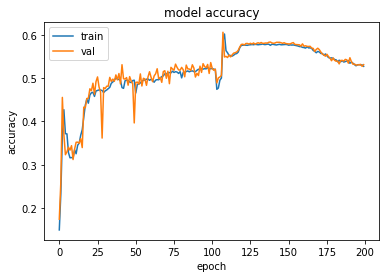

In [13]:
miniModel = Sequential()
miniModel.add(Input(shape=(None,3)))
miniModel.add(Dense(10))
miniModel.add(Dense(10))
miniModel.add(LSTM(64, return_sequences=True))
# miniModel.add(LSTM(32, return_sequences=True))
# miniModel.add(LSTM(16, return_sequences=True))
miniModel.add(LSTM(8))
miniModel.add(Dense(y_train.shape[-1], 'sigmoid'))
miniModel.compile('adam', loss='binary_crossentropy', metrics=['acc',tf.keras.metrics.Precision(thresholds=0.4),tf.keras.metrics.Recall(thresholds=0.4)])
history = miniModel.fit(X_train, y_train, batch_size=512, epochs=200, validation_data=(X_valid, y_valid))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
p_valid = miniModel.predict(X_valid)

In [15]:
from sklearn.metrics import roc_curve, plot_roc_curve

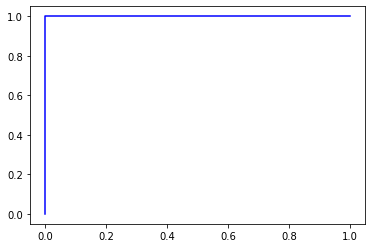

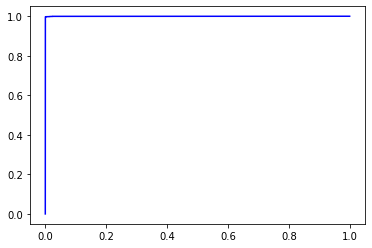

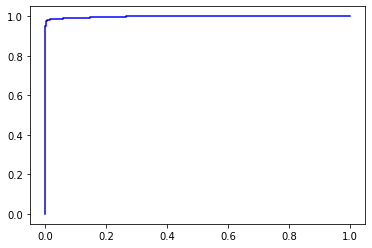

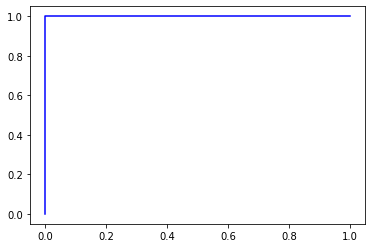

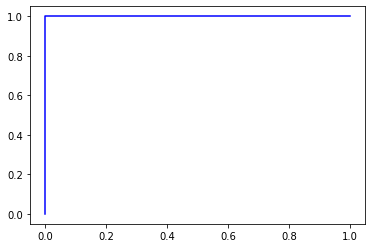

In [16]:
for i in range(5):
    fpr, tpr, threshold = roc_curve(y_valid.numpy()[:,i],p_valid[:,i])
    plt.plot(fpr, tpr, 'b')
    plt.show()

In [49]:
for i in random.sample(range(0, 15000), 10):
    print(p_valid[i], y_valid[i])
    print("###########################################################")
    

[0.71322566 0.5001814  0.48774964 0.03192484 0.03667786] tf.Tensor([1. 1. 0. 0. 0.], shape=(5,), dtype=float32)
###########################################################
[0.06034129 0.06585459 0.19471435 0.06835146 0.01269905] tf.Tensor([0. 0. 0. 0. 0.], shape=(5,), dtype=float32)
###########################################################
[0.20220664 0.2979014  0.26602855 0.906237   0.01835955] tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)
###########################################################
[0.6115387  0.5046338  0.36417273 0.0350249  0.02694007] tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)
###########################################################
[0.17834157 0.26735312 0.23656024 0.8718697  0.02045879] tf.Tensor([0. 1. 1. 1. 0.], shape=(5,), dtype=float32)
###########################################################
[0.71569145 0.50135106 0.49034566 0.0320709  0.03777572] tf.Tensor([1. 1. 0. 0. 0.], shape=(5,), dtype=float32)
############################

## Second model

Epoch 1/50
9/9 [==============================] - 4s 179ms/step - loss: 0.6881 - acc: 0.1701 - val_loss: 0.6909 - val_acc: 0.4826
Epoch 2/50
9/9 [==============================] - 1s 102ms/step - loss: 0.6794 - acc: 0.3030 - val_loss: 0.6887 - val_acc: 0.1432
Epoch 3/50
9/9 [==============================] - 1s 101ms/step - loss: 0.6753 - acc: 0.1546 - val_loss: 0.6866 - val_acc: 0.1102
Epoch 4/50
9/9 [==============================] - 1s 101ms/step - loss: 0.6732 - acc: 0.1186 - val_loss: 0.6844 - val_acc: 0.1102
Epoch 5/50
9/9 [==============================] - 1s 102ms/step - loss: 0.6712 - acc: 0.1605 - val_loss: 0.6824 - val_acc: 0.1863
Epoch 6/50
9/9 [==============================] - 1s 102ms/step - loss: 0.6694 - acc: 0.1840 - val_loss: 0.6803 - val_acc: 0.1863
Epoch 7/50
9/9 [==============================] - 1s 103ms/step - loss: 0.6677 - acc: 0.1871 - val_loss: 0.6783 - val_acc: 0.1863
Epoch 8/50
9/9 [==============================] - 1s 102ms/step - loss: 0.6657 - acc: 0.16

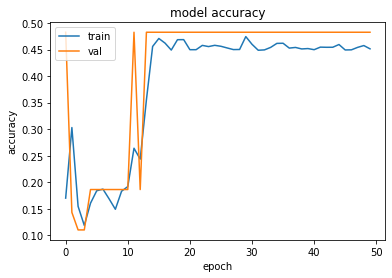

In [17]:
def custom(x):
#     tf.print(x[1])
    return tf.gather_nd(x[0],x[1])
inp = Input(shape=(None,3))
dense = Dense(10)(inp)
lstm = LSTM(64, return_sequences=True)(inp)
lstm = LSTM(32, return_sequences=True)(lstm)
lstm = LSTM(16, return_sequences=True)(lstm)
inp_lengths = Input(shape=(2), dtype=tf.int32)
lmbda = Lambda(custom)((lstm, inp_lengths))
final = Dense(y_train.shape[-1], 'sigmoid')(lmbda)


model = Model(inputs=[inp, inp_lengths], outputs=[final])
model.compile('adam', loss='binary_crossentropy', metrics='acc')

history = model.fit([X_train, lengths_train], y_train, batch_size=512, epochs=200, validation_data=([X_valid, lengths_valid], y_valid))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
X_train.shape, y_train.shape

(TensorShape([35000, 59, 3]), TensorShape([35000, 5]))

In [11]:
from itertools import chain, combinations

In [54]:
def train_model(cls, signals):
    X_train_l, y_train_l = tf.gather(X_train, signals, axis=2), tf.gather(y_train, cls, axis=1)
    X_valid_l, y_valid_l = tf.gather(X_valid, signals, axis=2), tf.gather(y_valid, cls, axis=1)
    miniModel = Sequential()
    miniModel.add(Input(shape=(None,len(signals))))
    miniModel.add(Dense(10))
    miniModel.add(Dense(10))
    miniModel.add(LSTM(64, return_sequences=True))
    # miniModel.add(LSTM(32, return_sequences=True))
    # miniModel.add(LSTM(16, return_sequences=True))
    miniModel.add(LSTM(8))
    miniModel.add(Dense(1, 'sigmoid'))
    miniModel.compile('adam', loss='binary_crossentropy', metrics=['acc',tf.keras.metrics.Precision(thresholds=0.4, name="precision"),tf.keras.metrics.Recall(thresholds=0.4, name= "recall")])
    history = miniModel.fit(X_train_l, y_train_l, batch_size=512, epochs=80, validation_data=(X_valid_l, y_valid_l))
    precision = history.history["val_precision"][-1]
    recall = history.history["val_recall"][-1]
    return (cls,signals, miniModel, precision, recall)

In [58]:
all_models = []
for cls in range(5):
    found_good = False
    for size in range(1,4):
        for comb in combinations([0,1,2], size):
            print("################################")
            print(cls,comb)
            print("##################################")
            result = train_model(cls, comb)
            all_models.append(result)

################################
0 (0,)
##################################
Epoch 1/80
69/69 [==============================] - 4s 27ms/step - loss: 0.5809 - acc: 0.7406 - precision: 0.2498 - recall: 0.1265 - val_loss: 0.5595 - val_acc: 0.7526 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/80
69/69 [==============================] - 1s 20ms/step - loss: 0.5647 - acc: 0.7465 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5593 - val_acc: 0.7526 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/80
69/69 [==============================] - 1s 20ms/step - loss: 0.5659 - acc: 0.7465 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5588 - val_acc: 0.7526 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/80
69/69 [==============================] - 1s 19ms/step - loss: 0.5548 - acc: 0.7465 - precision: 0.2857 - recall: 2.2540e-04 - val_loss: 0.5424 - val_acc: 0.7526 - val_precision: 0.3913 - val_recall: 0.2026
Epoch 5/80
69/69 [===========

Epoch 39/80
69/69 [==============================] - 2s 22ms/step - loss: 0.0116 - acc: 0.9979 - precision: 0.9984 - recall: 0.9934 - val_loss: 0.0101 - val_acc: 0.9981 - val_precision: 1.0000 - val_recall: 0.9930
Epoch 40/80
69/69 [==============================] - 1s 17ms/step - loss: 0.0094 - acc: 0.9985 - precision: 0.9994 - recall: 0.9952 - val_loss: 0.0071 - val_acc: 0.9990 - val_precision: 0.9987 - val_recall: 0.9973
Epoch 41/80
69/69 [==============================] - 1s 18ms/step - loss: 0.0102 - acc: 0.9980 - precision: 0.9977 - recall: 0.9943 - val_loss: 0.0092 - val_acc: 0.9979 - val_precision: 0.9928 - val_recall: 0.9973
Epoch 42/80
69/69 [==============================] - 1s 19ms/step - loss: 0.0140 - acc: 0.9972 - precision: 0.9978 - recall: 0.9912 - val_loss: 0.0176 - val_acc: 0.9952 - val_precision: 0.9832 - val_recall: 0.9938
Epoch 43/80
69/69 [==============================] - 1s 19ms/step - loss: 0.0151 - acc: 0.9966 - precision: 0.9959 - recall: 0.9900 - val_loss: 

69/69 [==============================] - 1s 16ms/step - loss: 7.3475e-04 - acc: 0.9999 - precision: 1.0000 - recall: 0.9998 - val_loss: 9.0130e-04 - val_acc: 0.9999 - val_precision: 1.0000 - val_recall: 0.9997
Epoch 78/80
69/69 [==============================] - 1s 17ms/step - loss: 6.9717e-04 - acc: 0.9999 - precision: 1.0000 - recall: 0.9998 - val_loss: 6.9414e-04 - val_acc: 0.9999 - val_precision: 1.0000 - val_recall: 0.9997
Epoch 79/80
69/69 [==============================] - 1s 19ms/step - loss: 6.5549e-04 - acc: 0.9999 - precision: 1.0000 - recall: 0.9998 - val_loss: 6.1635e-04 - val_acc: 0.9999 - val_precision: 1.0000 - val_recall: 0.9997
Epoch 80/80
69/69 [==============================] - 1s 16ms/step - loss: 6.2150e-04 - acc: 0.9999 - precision: 1.0000 - recall: 0.9998 - val_loss: 5.6116e-04 - val_acc: 0.9999 - val_precision: 1.0000 - val_recall: 1.0000
Found good model!!
################################
1 (0,)
##################################
Epoch 1/80
69/69 [============

Epoch 68/80
69/69 [==============================] - 1s 21ms/step - loss: 0.5591 - acc: 0.7527 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5613 - val_acc: 0.7511 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 69/80
69/69 [==============================] - 1s 21ms/step - loss: 0.5593 - acc: 0.7527 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5613 - val_acc: 0.7511 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 70/80
69/69 [==============================] - 2s 22ms/step - loss: 0.5591 - acc: 0.7527 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5612 - val_acc: 0.7511 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 71/80
69/69 [==============================] - 1s 19ms/step - loss: 0.5590 - acc: 0.7527 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5613 - val_acc: 0.7511 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 72/80
69/69 [==============================] - 1s 18ms/step - loss: 0.5591

69/69 [==============================] - 1s 17ms/step - loss: 0.0087 - acc: 0.9984 - precision: 0.9984 - recall: 0.9951 - val_loss: 0.0084 - val_acc: 0.9985 - val_precision: 1.0000 - val_recall: 0.9944
Epoch 26/80
69/69 [==============================] - 1s 21ms/step - loss: 0.0097 - acc: 0.9983 - precision: 0.9980 - recall: 0.9949 - val_loss: 0.0079 - val_acc: 0.9986 - val_precision: 0.9976 - val_recall: 0.9960
Epoch 27/80
69/69 [==============================] - 1s 17ms/step - loss: 0.0080 - acc: 0.9985 - precision: 0.9988 - recall: 0.9950 - val_loss: 0.0084 - val_acc: 0.9986 - val_precision: 0.9989 - val_recall: 0.9954
Epoch 28/80
69/69 [==============================] - 1s 16ms/step - loss: 0.0116 - acc: 0.9980 - precision: 0.9975 - recall: 0.9943 - val_loss: 0.0102 - val_acc: 0.9979 - val_precision: 1.0000 - val_recall: 0.9917
Epoch 29/80
69/69 [==============================] - 1s 20ms/step - loss: 0.0099 - acc: 0.9979 - precision: 0.9961 - recall: 0.9951 - val_loss: 0.0065 - val

Epoch 20/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5635 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5624 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 21/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5635 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5626 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 22/80
69/69 [==============================] - 1s 17ms/step - loss: 0.5636 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5624 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 23/80
69/69 [==============================] - 1s 19ms/step - loss: 0.5636 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5624 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 24/80
69/69 [==============================] - 1s 20ms/step - loss: 0.5636

Epoch 56/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5635 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5624 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 57/80
69/69 [==============================] - 1s 17ms/step - loss: 0.5635 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5626 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 58/80
69/69 [==============================] - 1s 18ms/step - loss: 0.5634 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5624 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 59/80
69/69 [==============================] - 1s 17ms/step - loss: 0.5635 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5625 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 60/80
69/69 [==============================] - 1s 17ms/step - loss: 0.5635

Epoch 47/80
69/69 [==============================] - 1s 17ms/step - loss: 0.5635 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5624 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 48/80
69/69 [==============================] - 1s 17ms/step - loss: 0.5635 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5624 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 49/80
69/69 [==============================] - 1s 17ms/step - loss: 0.5635 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5624 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 50/80
69/69 [==============================] - 1s 17ms/step - loss: 0.5635 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5626 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 51/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5636

69/69 [==============================] - 1s 16ms/step - loss: 0.5634 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5624 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 39/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5633 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5627 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 40/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5633 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5622 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 41/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5632 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5621 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 42/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5627 - acc: 0.74

Epoch 75/80
69/69 [==============================] - 1s 15ms/step - loss: 0.0991 - acc: 0.9726 - precision: 0.9698 - recall: 0.9183 - val_loss: 0.0849 - val_acc: 0.9765 - val_precision: 0.9880 - val_recall: 0.9208
Epoch 76/80
69/69 [==============================] - 1s 16ms/step - loss: 0.0881 - acc: 0.9766 - precision: 0.9756 - recall: 0.9281 - val_loss: 0.0850 - val_acc: 0.9777 - val_precision: 0.9951 - val_recall: 0.9184
Epoch 77/80
69/69 [==============================] - 1s 15ms/step - loss: 0.0822 - acc: 0.9781 - precision: 0.9782 - recall: 0.9332 - val_loss: 0.0713 - val_acc: 0.9820 - val_precision: 0.9660 - val_recall: 0.9544
Epoch 78/80
69/69 [==============================] - 1s 15ms/step - loss: 0.0712 - acc: 0.9820 - precision: 0.9824 - recall: 0.9440 - val_loss: 0.0633 - val_acc: 0.9842 - val_precision: 0.9712 - val_recall: 0.9613
Epoch 79/80
69/69 [==============================] - 1s 15ms/step - loss: 0.0740 - acc: 0.9813 - precision: 0.9814 - recall: 0.9417 - val_loss: 

Epoch 31/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5636 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5626 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 32/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5636 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5626 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 33/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5636 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5624 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 34/80
69/69 [==============================] - 1s 17ms/step - loss: 0.5635 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5627 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 35/80
69/69 [==============================] - 1s 15ms/step - loss: 0.5636

Epoch 67/80
69/69 [==============================] - 1s 15ms/step - loss: 0.5636 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5624 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 68/80
69/69 [==============================] - 1s 15ms/step - loss: 0.5635 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5624 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 69/80
69/69 [==============================] - 1s 15ms/step - loss: 0.5635 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5625 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 70/80
69/69 [==============================] - 1s 15ms/step - loss: 0.5634 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5624 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 71/80
69/69 [==============================] - 1s 15ms/step - loss: 0.5634

Epoch 24/80
69/69 [==============================] - 1s 15ms/step - loss: 0.2540 - acc: 0.9180 - precision: 0.9249 - recall: 0.7272 - val_loss: 0.2860 - val_acc: 0.9011 - val_precision: 0.9919 - val_recall: 0.6185
Epoch 25/80
69/69 [==============================] - 1s 16ms/step - loss: 0.2075 - acc: 0.9338 - precision: 0.9404 - recall: 0.7873 - val_loss: 0.1805 - val_acc: 0.9438 - val_precision: 0.9290 - val_recall: 0.8339
Epoch 26/80
69/69 [==============================] - 1s 15ms/step - loss: 0.1948 - acc: 0.9397 - precision: 0.9393 - recall: 0.8089 - val_loss: 0.1714 - val_acc: 0.9479 - val_precision: 0.9808 - val_recall: 0.8152
Epoch 27/80
69/69 [==============================] - 1s 15ms/step - loss: 0.1741 - acc: 0.9465 - precision: 0.9412 - recall: 0.8339 - val_loss: 0.1801 - val_acc: 0.9451 - val_precision: 0.9904 - val_recall: 0.7953
Epoch 28/80
69/69 [==============================] - 1s 16ms/step - loss: 0.1900 - acc: 0.9392 - precision: 0.9288 - recall: 0.8163 - val_loss: 

69/69 [==============================] - 1s 15ms/step - loss: 0.5611 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5641 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 20/80
69/69 [==============================] - 1s 15ms/step - loss: 0.5633 - acc: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5613 - val_acc: 0.7499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 21/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5568 - acc: 0.7490 - precision: 0.5753 - recall: 0.0217 - val_loss: 0.5313 - val_acc: 0.7499 - val_precision: 0.6261 - val_recall: 0.2330
Epoch 22/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5456 - acc: 0.7614 - precision: 0.6696 - recall: 0.1040 - val_loss: 0.5545 - val_acc: 0.7513 - val_precision: 1.0000 - val_recall: 0.0067
Epoch 23/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5473 - acc: 0.7564 - precision: 0.5505 - recall:

69/69 [==============================] - 1s 15ms/step - loss: 0.0354 - acc: 0.9896 - precision: 0.9899 - recall: 0.9687 - val_loss: 0.0302 - val_acc: 0.9919 - val_precision: 0.9913 - val_recall: 0.9747
Epoch 58/80
69/69 [==============================] - 1s 16ms/step - loss: 0.0303 - acc: 0.9911 - precision: 0.9903 - recall: 0.9737 - val_loss: 0.0293 - val_acc: 0.9915 - val_precision: 0.9959 - val_recall: 0.9707
Epoch 59/80
69/69 [==============================] - 1s 15ms/step - loss: 0.0337 - acc: 0.9897 - precision: 0.9861 - recall: 0.9718 - val_loss: 0.0387 - val_acc: 0.9891 - val_precision: 0.9838 - val_recall: 0.9704
Epoch 60/80
69/69 [==============================] - 1s 15ms/step - loss: 0.0302 - acc: 0.9911 - precision: 0.9895 - recall: 0.9747 - val_loss: 0.0345 - val_acc: 0.9913 - val_precision: 0.9818 - val_recall: 0.9795
Epoch 61/80
69/69 [==============================] - 1s 15ms/step - loss: 0.0319 - acc: 0.9911 - precision: 0.9904 - recall: 0.9727 - val_loss: 0.0514 - val

69/69 [==============================] - 1s 16ms/step - loss: 0.5651 - acc: 0.7475 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5670 - val_acc: 0.7457 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 15/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5651 - acc: 0.7475 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5672 - val_acc: 0.7457 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 16/80
69/69 [==============================] - 1s 15ms/step - loss: 0.5652 - acc: 0.7475 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5671 - val_acc: 0.7457 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 17/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5654 - acc: 0.7475 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5670 - val_acc: 0.7457 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 18/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5652 - acc: 0.74

Epoch 50/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5651 - acc: 0.7475 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5670 - val_acc: 0.7457 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 51/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5652 - acc: 0.7475 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5670 - val_acc: 0.7457 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 52/80
69/69 [==============================] - 1s 15ms/step - loss: 0.5652 - acc: 0.7475 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5670 - val_acc: 0.7457 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 53/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5652 - acc: 0.7475 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5670 - val_acc: 0.7457 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 54/80
69/69 [==============================] - 1s 16ms/step - loss: 0.5651

Epoch 6/80
69/69 [==============================] - 1s 17ms/step - loss: 0.0150 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0134 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 7/80
69/69 [==============================] - 1s 17ms/step - loss: 0.0121 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0110 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 8/80
69/69 [==============================] - 1s 16ms/step - loss: 0.0100 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0092 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 9/80
69/69 [==============================] - 1s 15ms/step - loss: 0.0085 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0079 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 10/80
69/69 [==============================] - 1s 16ms/step - loss: 0.0073 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.00

Epoch 44/80
69/69 [==============================] - 1s 16ms/step - loss: 5.9765e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.8526e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 45/80
69/69 [==============================] - 1s 16ms/step - loss: 5.6981e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.5820e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 46/80
69/69 [==============================] - 1s 15ms/step - loss: 5.4358e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.3265e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 47/80
69/69 [==============================] - 1s 15ms/step - loss: 5.1882e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.0854e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 48/80
69/69 [==============================] - 1s 16ms/step - loss: 4.9545e-04 - acc: 1.0000 - precision: 

Found good model!!
################################
4 (0,)
##################################
Epoch 1/80
69/69 [==============================] - 4s 24ms/step - loss: 0.4208 - acc: 0.8339 - precision: 0.5560 - recall: 0.5672 - val_loss: 0.1226 - val_acc: 0.9943 - val_precision: 0.9937 - val_recall: 0.9856
Epoch 2/80
69/69 [==============================] - 1s 16ms/step - loss: 0.0717 - acc: 0.9978 - precision: 0.9968 - recall: 0.9945 - val_loss: 0.0402 - val_acc: 0.9991 - val_precision: 1.0000 - val_recall: 0.9973
Epoch 3/80
69/69 [==============================] - 1s 16ms/step - loss: 0.1598 - acc: 0.9602 - precision: 0.9292 - recall: 0.9138 - val_loss: 0.0710 - val_acc: 0.9957 - val_precision: 0.9970 - val_recall: 0.9894
Epoch 4/80
69/69 [==============================] - 1s 16ms/step - loss: 0.0446 - acc: 0.9986 - precision: 0.9992 - recall: 0.9957 - val_loss: 0.0258 - val_acc: 0.9993 - val_precision: 1.0000 - val_recall: 0.9976
Epoch 5/80
69/69 [==============================] - 1s

Epoch 75/80
69/69 [==============================] - 1s 17ms/step - loss: 1.1678e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1688e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 76/80
69/69 [==============================] - 1s 16ms/step - loss: 1.1241e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1114e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 77/80
69/69 [==============================] - 1s 15ms/step - loss: 1.0821e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.0710e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 78/80
69/69 [==============================] - 1s 17ms/step - loss: 1.0420e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.0351e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 79/80
69/69 [==============================] - 1s 15ms/step - loss: 1.0032e-04 - acc: 1.0000 - precision: 

In [72]:
all_models.append(train_model(4,(2,)))

Epoch 1/80
69/69 [==============================] - 12s 65ms/step - loss: 0.3667 - acc: 0.8732 - precision: 0.6538 - recall: 0.6568 - val_loss: 0.1597 - val_acc: 0.9692 - val_precision: 0.9942 - val_recall: 0.8864
Epoch 2/80
69/69 [==============================] - 3s 38ms/step - loss: 0.1115 - acc: 0.9788 - precision: 0.9702 - recall: 0.9458 - val_loss: 0.0680 - val_acc: 0.9887 - val_precision: 0.9854 - val_recall: 0.9702
Epoch 3/80
69/69 [==============================] - 3s 41ms/step - loss: 0.0560 - acc: 0.9899 - precision: 0.9893 - recall: 0.9710 - val_loss: 0.0421 - val_acc: 0.9931 - val_precision: 0.9953 - val_recall: 0.9778
Epoch 4/80
69/69 [==============================] - 3s 39ms/step - loss: 0.0365 - acc: 0.9941 - precision: 0.9941 - recall: 0.9832 - val_loss: 0.0249 - val_acc: 0.9968 - val_precision: 0.9978 - val_recall: 0.9919
Epoch 5/80
69/69 [==============================] - 3s 40ms/step - loss: 0.0232 - acc: 0.9972 - precision: 0.9969 - recall: 0.9931 - val_loss: 0.01

Epoch 39/80
69/69 [==============================] - 3s 42ms/step - loss: 5.4756e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.2166e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 40/80
69/69 [==============================] - 3s 38ms/step - loss: 5.1923e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.9560e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 41/80
69/69 [==============================] - 3s 42ms/step - loss: 4.9303e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.7090e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 42/80
69/69 [==============================] - 3s 42ms/step - loss: 4.6847e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.4780e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 43/80
69/69 [==============================] - 3s 41ms/step - loss: 4.4565e-04 - acc: 1.0000 - precision: 

Epoch 76/80
69/69 [==============================] - 3s 40ms/step - loss: 1.0945e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.0659e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 77/80
69/69 [==============================] - 3s 40ms/step - loss: 1.0535e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.0297e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 78/80
69/69 [==============================] - 3s 41ms/step - loss: 1.0142e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 9.9378e-05 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 79/80
69/69 [==============================] - 3s 41ms/step - loss: 9.7661e-05 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 9.5909e-05 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 80/80
69/69 [==============================] - 3s 41ms/step - loss: 9.4032e-05 - acc: 1.0000 - precision: 

In [98]:
for res in all_models:
    print(res)

(0, (0,), <keras.engine.sequential.Sequential object at 0x7efbfe674880>, 1.0, 1.0)
(1, (0,), <keras.engine.sequential.Sequential object at 0x7efab813cdf0>, 0.0, 0.0)
(1, (1,), <keras.engine.sequential.Sequential object at 0x7efab8714580>, 1.0, 0.9973219037055969)
(2, (0,), <keras.engine.sequential.Sequential object at 0x7efab02c8d60>, 0.0, 0.0)
(2, (1,), <keras.engine.sequential.Sequential object at 0x7efb5c2e5580>, 0.0, 0.0)
(2, (2,), <keras.engine.sequential.Sequential object at 0x7efb6c483970>, 0.9820652008056641, 0.9634764194488525)
(2, (0, 1), <keras.engine.sequential.Sequential object at 0x7efaf4112910>, 0.0, 0.0)
(2, (0, 2), <keras.engine.sequential.Sequential object at 0x7efb0dbbae50>, 0.9989100694656372, 0.9773393869400024)
(2, (1, 2), <keras.engine.sequential.Sequential object at 0x7efb0d98afd0>, 0.9887790679931641, 0.986670196056366)
(3, (0,), <keras.engine.sequential.Sequential object at 0x7efb0d87e190>, 0.0, 0.0)
(3, (1,), <keras.engine.sequential.Sequential object at 0x7e

# filter

In [109]:
filtered = []
for cls,signals,model,prec,rec in all_models:
    if prec <= 0.5 or rec <= 0.5:
        continue
    if len(signals) > 1:
        if any(res[3] <= 0.5 or res[4] <= 0.5 for res in all_models if res[0] == cls and len(res[1])==1 and res[1][0] in signals):
            continue
    filtered.append((cls,signals,model,prec,rec))
for f in filtered:
    print(f)

(0, (0,), <keras.engine.sequential.Sequential object at 0x7efbfe674880>, 1.0, 1.0)
(1, (1,), <keras.engine.sequential.Sequential object at 0x7efab8714580>, 1.0, 0.9973219037055969)
(2, (2,), <keras.engine.sequential.Sequential object at 0x7efb6c483970>, 0.9820652008056641, 0.9634764194488525)
(3, (1,), <keras.engine.sequential.Sequential object at 0x7efb0f9ddfd0>, 1.0, 1.0)
(4, (0,), <keras.engine.sequential.Sequential object at 0x7efaa1768820>, 1.0, 1.0)
(4, (0, 2), <keras.engine.sequential.Sequential object at 0x7efb07056370>, 1.0, 1.0)
(4, (2,), <keras.engine.sequential.Sequential object at 0x7efaf79ddc10>, 1.0, 1.0)


In [115]:
for cls,signals,model,prec,rec in filtered:
    model_json = model.to_json()
    with open(f"models/model_{cls}_{signals}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"models/model_{cls}_{signals}.h5")
    print("Saved model to disk")
    

Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk


In [165]:
good_models = []

In [166]:
from pathlib import Path
from tensorflow.keras.models import model_from_json

In [167]:
for path in [p for p in Path("models").iterdir() if p.suffix == ".json"]:
    json_file = open(str(path), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(f"models/{path.stem}.h5")
    loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc',tf.keras.metrics.Precision(thresholds=0.4),tf.keras.metrics.Recall(thresholds=0.4)])
    print("Loaded model from disk")
    splitted = path.stem.split("_")
    cls = int(splitted[1])
    signals = [int(num) for num in splitted[2][1:-1].split(",") if num]
    print(cls,signals)
    good_models.append((cls,signals,loaded_model))
 

Loaded model from disk
3 [1]
Loaded model from disk
0 [0]
Loaded model from disk
1 [1]
Loaded model from disk
2 [2]
Loaded model from disk
4 [0, 2]
Loaded model from disk
4 [0]
Loaded model from disk
4 [2]


In [168]:
good_models

[(3, [1], <keras.engine.sequential.Sequential at 0x7efaf7e8b910>),
 (0, [0], <keras.engine.sequential.Sequential at 0x7efaa9bd52b0>),
 (1, [1], <keras.engine.sequential.Sequential at 0x7efab1643700>),
 (2, [2], <keras.engine.sequential.Sequential at 0x7efaf7e49e20>),
 (4, [0, 2], <keras.engine.sequential.Sequential at 0x7efab165ef40>),
 (4, [0], <keras.engine.sequential.Sequential at 0x7efaa9a895e0>),
 (4, [2], <keras.engine.sequential.Sequential at 0x7efaf7e57310>)]

In [169]:
class SuperModel():
    def __init__(cls,signals,model,submodels):
        self.cls = cls
        self.signals = signals
        self.submodels = {}
        for cs,sg,model in submodels:
            self.submodels[sg[0]] = model
        
    def predict(self,X):
        return sel.model.predict(tf.gather(X, self.signals, axis=2))
    
    def explain_single(self,x):
        for signal,model in self.submodels.items():
            start, finish = 0,x.shape[1]
            while True:
                new_start,new_finish = 999,-1
                l = finish-start
                for i in range(6):
                    s,f = start+i*(l//8), start+(i+2)*(l//8)
                    print(s,f)
                return
            
        
    

In [180]:
y[0]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 1.], dtype=float32)>

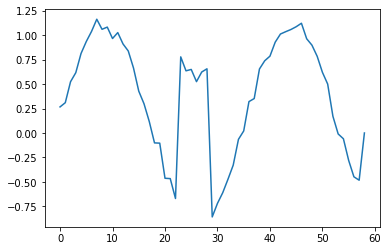

In [186]:
plt.plot(X[0,:,])
plt.show()

In [189]:
cls,signals, model = good_models[0]
signal = signals[0]
print(type(cls))
print(signal)
start, finish = 0,59
while True:
    new_start,new_finish = 999,-1
    l = finish-start
    for i in range(8):
        s,f = start+i*(l//8), min(start+(i+2)*(l//8), finish)
        print(s,f)
        print(X[0:1,s:f,signal:signal+1])
        print(model.predict(X[0:1,0:f,signal:signal+1]))
        if True:#model found sth
            new_start = min(new_start, s)
            new_finish = max(new_finish, f)
    if new_start == start and new_finish == finish:
        break
    start, finish = new_start, new_finish
    break

<class 'int'>
1
0 14
tf.Tensor(
[[[ 0.48574278]
  [ 0.7245592 ]
  [ 0.8955255 ]
  [ 1.0101544 ]
  [ 1.1560017 ]
  [ 1.0941502 ]
  [ 0.9175775 ]
  [ 0.92201954]
  [ 0.54237837]
  [ 0.30428258]
  [ 0.19900708]
  [-0.18445724]
  [-0.45634368]
  [-0.51709527]]], shape=(1, 14, 1), dtype=float32)
[[0.99963295]]
7 21
tf.Tensor(
[[[ 0.92201954]
  [ 0.54237837]
  [ 0.30428258]
  [ 0.19900708]
  [-0.18445724]
  [-0.45634368]
  [-0.51709527]
  [-0.68251854]
  [-0.958532  ]
  [-0.9456677 ]
  [-0.90550166]
  [-0.69509214]
  [-0.5345135 ]
  [-0.31065106]]], shape=(1, 14, 1), dtype=float32)
[[0.99963427]]
14 28
tf.Tensor(
[[[-0.68251854]
  [-0.958532  ]
  [-0.9456677 ]
  [-0.90550166]
  [-0.69509214]
  [-0.5345135 ]
  [-0.31065106]
  [-0.07081757]
  [ 0.06266696]
  [ 0.3674488 ]
  [ 0.60680825]
  [ 0.9214602 ]
  [ 1.036375  ]
  [ 1.1345189 ]]], shape=(1, 14, 1), dtype=float32)
[[0.999635]]
21 35
tf.Tensor(
[[[-0.07081757]
  [ 0.06266696]
  [ 0.3674488 ]
  [ 0.60680825]
  [ 0.9214602 ]
  [ 1.036375  ]

In [154]:
X[0,0:10,2]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.36391428, 0.54140264, 0.6616599 , 0.70790654, 0.7610961 ,
       0.8069586 , 0.876103  , 1.0782043 , 1.0940691 , 1.0836558 ],
      dtype=float32)>

In [135]:
model = Sequential()
model.add(Reshape((-1,10,1), input_shape=(60,1)))
model.add(TimeDistributed(good_models[0][2]))
model.add(GlobalMaxPool1D())
model.compile('adam', loss='binary_crossentropy', metrics='acc')
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 6, 10, 1)          0         
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             21675     
 ibuted)                                                         
                                                                 
 global_max_pooling1d (Globa  (None, 1)                0         
 lMaxPooling1D)                                                  
                                                                 
Total params: 21,675
Trainable params: 21,675
Non-trainable params: 0
_________________________________________________________________
